# Marketing Churn Analysis

Author: Sandra Shtabnaya<br>
Course: DSCI 401 - Applied Machine Learning<br>
Description: This notebook uses a k-Nearest-Neighbor (kNN) classifier that I wrote from scratch to predict the churn rate for customers.

In [247]:
import pandas as pd
import matplotlib.pyplot as plt

from knn import *
from scipy.spatial import distance

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline

### Error Metrics ###
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score

from sklearn import ensemble
from sklearn import tree
from sklearn import svm
from sklearn import naive_bayes
from sklearn import linear_model

from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

In [248]:
churn_data = pd.read_csv("churn_data.csv")
churn_validation = pd.read_csv("churn_validation.csv")

## Data Exploration
To predict churn (our response variable), we have available the predictor variables customer ID, gender, age, income bracket, family size, education, and total calls and visits. There are two columns that are categorical (income and gender), which will have to be one-hot encoded. There are no missing values to impute.

In [249]:
churn_data.info()
print()
churn_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 9 columns):
CustID        128 non-null int64
Gender        128 non-null object
Age           128 non-null int64
Income        128 non-null object
FamilySize    128 non-null int64
Education     128 non-null int64
Calls         128 non-null int64
Visits        128 non-null int64
Churn         128 non-null object
dtypes: int64(6), object(3)
memory usage: 9.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 9 columns):
CustID        32 non-null int64
Gender        32 non-null object
Age           32 non-null int64
Income        32 non-null object
FamilySize    32 non-null int64
Education     32 non-null int64
Calls         32 non-null int64
Visits        32 non-null int64
Churn         32 non-null object
dtypes: int64(6), object(3)
memory usage: 2.3+ KB


Our response variable has two possible values (Yes or No), so we will need to perform binary classification. Class counts are somewhat unbalanced, so we will use F1 macro score to evaluate our models.

In [250]:
churn_data.Churn.value_counts()

Yes    72
No     56
Name: Churn, dtype: int64

We can quickly view the distributions of the different variables in our datasets using a pairs-plot. Most of the columns are normally distributed. The majority of individuals in the training-testing set are under thirty years old. Education and family size also appear to be ordered categorical values.

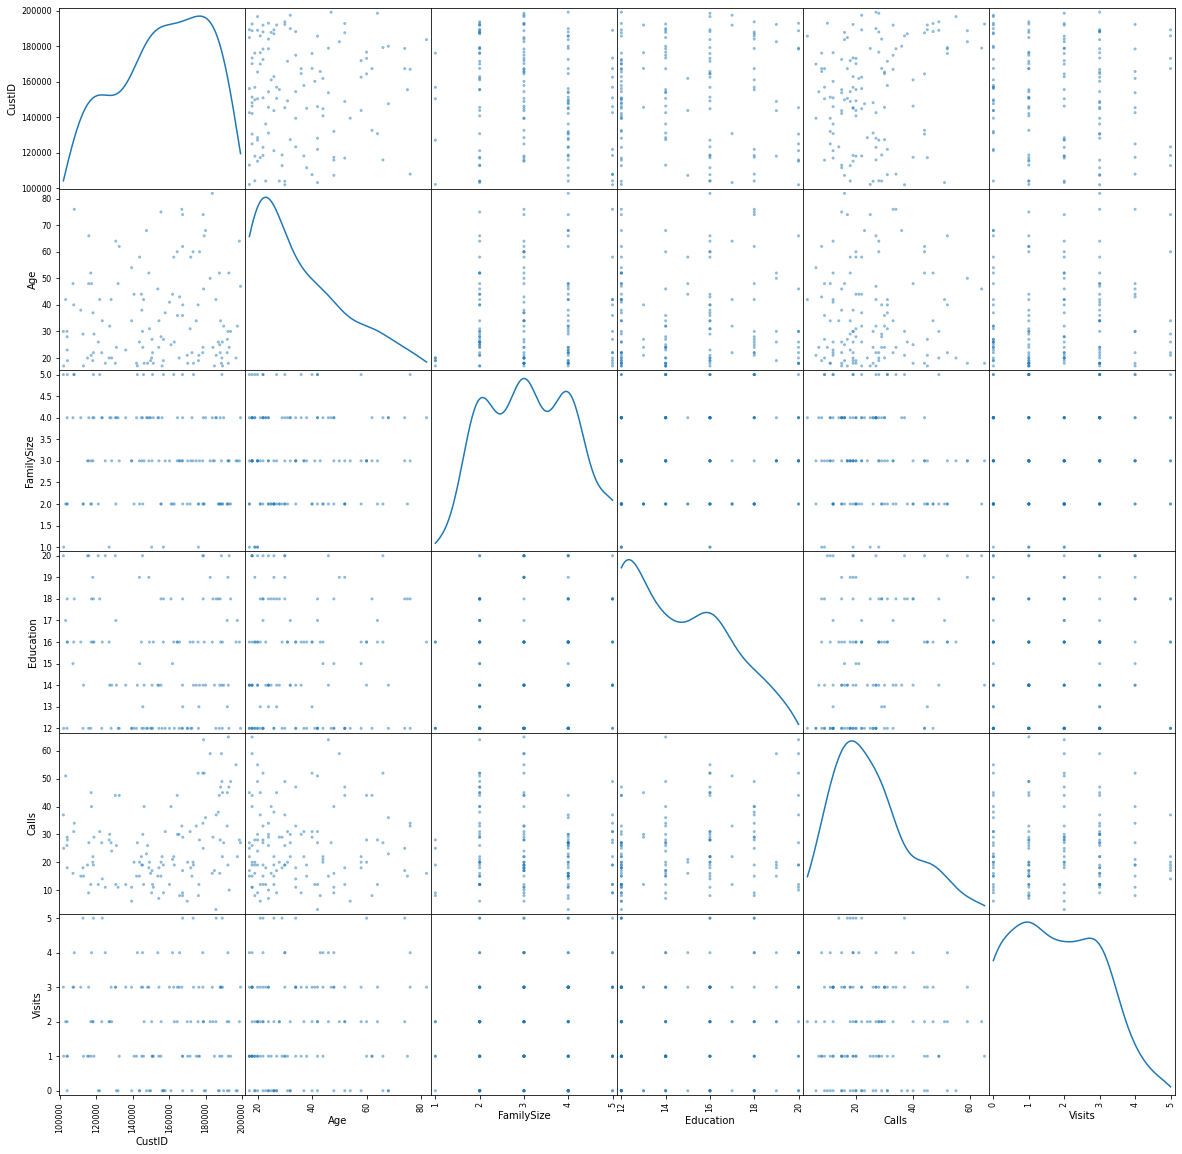

In [251]:
sm = pd.plotting.scatter_matrix(churn_data, diagonal='kde')
plt.rcParams["figure.figsize"] = [20, 20]
plt.show()

## Data Preparation
Since our kNN classifier needs to measure the distance between data observations, we will need to convert the categorical predictor variables into numbers (split the potential category values into one-hot columns). The response variable also needs to be converted into a number, which is required for our error metrics. We will use a label encoder, since we want the label to be in one column.

In [252]:
def cat_features(dataframe):
    td = pd.DataFrame({'a':[1,2,3], 'b':[1.0, 2.0, 3.0]})
    return [x for x in list(dataframe) if not(dataframe[x].dtype in [td['a'].dtype, td['b'].dtype])]

# Since the customer ID column is unique for each row, it does not provide useful 
# information for training, and so can be eliminated.
data_x = churn_data.drop(["Churn", "CustID"], axis=1)
data_y = churn_data.Churn

valid_x = churn_validation.drop(["Churn", "CustID"], axis=1)
valid_y = churn_validation.Churn

data_x = pd.get_dummies(data_x, columns=cat_features(data_x))
valid_x = pd.get_dummies(valid_x, columns=cat_features(valid_x))
df_data_x = data_x  # save transformed data as dataframe

encoder = preprocessing.LabelEncoder()
data_y = encoder.fit_transform(data_y)
valid_y = encoder.fit_transform(valid_y)

It is also important to normalize the data so that all columns are weighed evenly and distance isn't affected by one single column. We will use the preprocessing library for this.

In [253]:
data_x = preprocessing.normalize(data_x)
valid_x = preprocessing.normalize(valid_x)

## Error Metrics
To evaluate our kNN model, we will measure its accuracy (proportion of correct predictions), precision (proportion of correct "Yes"), recall (proportion of true "Yes"), harmonic mean (F1) of precision and recall, ROC AUC (area under the ROC curve, with 1 being perfect) and confusion matrix. The confusion matrix will enumerate the number of Type-I and Type-II errors (false positives and false negatives). These metrics will provide a bigger picture of the model's performance.

In [254]:
def print_binary_classif_error_report(y_test, preds):
    print('Accuracy: ' + str(accuracy_score(y_test, preds)))
    print('Precison: ' + str(precision_score(y_test, preds)))
    print('Recall: ' + str(recall_score(y_test, preds)))
    print('F1: ' + str(f1_score(y_test, preds)))
    print('ROC AUC: ' + str(roc_auc_score(y_test, preds)))
    print("Confusion Matrix:\n" + str(confusion_matrix(y_test, preds)))

## Compute Best KNN

### Try Different k-Values
To implement something similar to a grid search for our kNN classifier, we will try out all combinations of odd k-values between 1 and 21, and some popular distance functions.

In [297]:
k_vals = list(range(1, 22, 2))
dist_funcs = [distance.euclidean, distance.cityblock, distance.cosine, distance.minkowski]
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.3)

for k in k_vals:
    
    for dist in dist_funcs:
        print("k =", k, "distance =", dist)
        knn = KNN(k, dist)
        knn.fit(x_train, y_train)
        preds = knn.predict(x_test)
        print_binary_classif_error_report(y_test, preds)
        print()

best_knn = KNN(7, distance.cityblock)

k = 1 distance = <function euclidean at 0x000002A120736950>
Accuracy: 0.538461538462
Precison: 0.565217391304
Recall: 0.619047619048
F1: 0.590909090909
ROC AUC: 0.531746031746
Confusion Matrix:
[[ 8 10]
 [ 8 13]]

k = 1 distance = <function cityblock at 0x000002A120736D90>
Accuracy: 0.641025641026
Precison: 0.666666666667
Recall: 0.666666666667
F1: 0.666666666667
ROC AUC: 0.638888888889
Confusion Matrix:
[[11  7]
 [ 7 14]]

k = 1 distance = <function cosine at 0x000002A120736AE8>
Accuracy: 0.538461538462
Precison: 0.565217391304
Recall: 0.619047619048
F1: 0.590909090909
ROC AUC: 0.531746031746
Confusion Matrix:
[[ 8 10]
 [ 8 13]]

k = 1 distance = <function minkowski at 0x000002A120736840>
Accuracy: 0.538461538462
Precison: 0.565217391304
Recall: 0.619047619048
F1: 0.590909090909
ROC AUC: 0.531746031746
Confusion Matrix:
[[ 8 10]
 [ 8 13]]

k = 3 distance = <function euclidean at 0x000002A120736950>
Accuracy: 0.615384615385
Precison: 0.636363636364
Recall: 0.666666666667
F1: 0.65116279


k = 21 distance = <function euclidean at 0x000002A120736950>
Accuracy: 0.641025641026
Precison: 0.612903225806
Recall: 0.904761904762
F1: 0.730769230769
ROC AUC: 0.619047619048
Confusion Matrix:
[[ 6 12]
 [ 2 19]]

k = 21 distance = <function cityblock at 0x000002A120736D90>
Accuracy: 0.666666666667
Precison: 0.625
Recall: 0.952380952381
F1: 0.754716981132
ROC AUC: 0.642857142857
Confusion Matrix:
[[ 6 12]
 [ 1 20]]

k = 21 distance = <function cosine at 0x000002A120736AE8>
Accuracy: 0.641025641026
Precison: 0.612903225806
Recall: 0.904761904762
F1: 0.730769230769
ROC AUC: 0.619047619048
Confusion Matrix:
[[ 6 12]
 [ 2 19]]

k = 21 distance = <function minkowski at 0x000002A120736840>
Accuracy: 0.641025641026
Precison: 0.612903225806
Recall: 0.904761904762
F1: 0.730769230769
ROC AUC: 0.619047619048
Confusion Matrix:
[[ 6 12]
 [ 2 19]]



After performing the search, the estimated best parameter combination is k=7, using Manhattan distance. This model has a harmonic mean (F1 score) of between 80 and 60 percent. I performed this search several times, and a k of 7 did better in general. In some cases, however, all the distance functions had the same F1 score.

## Try Out Other Models
Let's try to build the best random forest, decision tree, naive Bayes, support vector machine and logistic regression classifiers, utilizing feature selection and grid search to find the optimal parameters and training sets for each model.

### Best Random Forest
We will attempt to build the best random forest model using grid search. To do this, we will create a pipeline to return our estimator, where we will first transform the data by conducting feature selection. This will allow us to eliminate predictor variables that act as noise. We will find the k-best features, starting from 1 to 9. Afterward, we will use the selected features for our random forest model. This way, we will allow grid search to find the optimal combination of parameters and features. Our model will be scored according to the harmonic mean.

In [256]:
pipeline = Pipeline(steps=[('selector', SelectKBest()), 
                           ('rf', ensemble.RandomForestClassifier(random_state=0))])

param_grid = {'selector__k': list(range(1, 10)), 
              'rf__n_estimators': list(range(10, 200, 10)),
              'rf__max_depth': [3, 6, None]}

rf = GridSearchCV(estimator=pipeline, scoring="f1_macro", cv=5, param_grid=param_grid)
rf.fit(x_train, y_train)

print("Grid Search CV Score (RF):", rf.score(x_test, y_test))
print("Best RF parameters: ", rf.best_params_)
best_rf = rf.best_estimator_.named_steps['rf']

Grid Search CV Score (RF): 0.658585858586
Best RF parameters:  {'rf__max_depth': 6, 'rf__n_estimators': 20, 'selector__k': 7}


### Best Support Vector Machine
We will use the same approach as the random forest (grid search with pipeline) above to estimate the best support vector machine.

In [257]:
pipeline = Pipeline(steps=[('selector', SelectKBest()), 
                           ('svm', svm.SVC(random_state=0))])

param_grid = {'selector__k': list(range(1, 10)), 
              'svm__C': np.arange(0.2, 10.1, .1)}

svm = GridSearchCV(estimator=pipeline, scoring="f1_macro", cv=5, param_grid=param_grid)
svm.fit(x_train, y_train)

print("Grid Search CV Score (SVM):", svm.score(x_test, y_test))
print("Best SVM parameters: ", svm.best_params_)
best_svm = svm.best_estimator_.named_steps['svm']

Grid Search CV Score (SVM): 0.589473684211
Best SVM parameters:  {'selector__k': 1, 'svm__C': 3.0000000000000009}


### Best Decision Tree

In [258]:
pipeline = Pipeline(steps=[('selector', SelectKBest()), 
                           ('dt', tree.DecisionTreeClassifier(random_state=0))])

param_grid = {'selector__k': list(range(1, 10)), 
              'dt__criterion': ["gini", "entropy"]}

dt = GridSearchCV(estimator=pipeline, scoring="f1_macro", cv=5, param_grid=param_grid)
dt.fit(x_train, y_train)

print("Grid Search CV Score (DT):", dt.score(x_test, y_test))
print("Best DT parameters: ", dt.best_params_)
best_dt = dt.best_estimator_.named_steps['dt']

Grid Search CV Score (DT): 0.682065217391
Best DT parameters:  {'dt__criterion': 'entropy', 'selector__k': 9}


### Best Naive Bayes
Since most of our numerical predictor variables were normally distributed (according to our pairs-plot), we can build a Gaussian Naive Bayes model. Because Naive Bayes is also a simple classifer, we can use it as a baseline for comparison. Surprisingly, it performed as well as the SVM, with an average harmonic mean of 59 percent.

In [259]:
pipeline = Pipeline(steps=[('selector', SelectKBest()), 
                           ('nb', naive_bayes.GaussianNB())])

param_grid = {'selector__k': list(range(1, 10))}

nb = GridSearchCV(estimator=pipeline, scoring="f1_macro", cv=5, param_grid=param_grid)
nb.fit(x_train, y_train)

print("Grid Search CV Score (NB):", nb.score(x_test, y_test))
print("Best NB parameters: ", nb.best_params_)
best_nb = nb.best_estimator_.named_steps['nb']

Grid Search CV Score (NB): 0.589473684211
Best NB parameters:  {'selector__k': 7}


### Best Logistic Regression

In [261]:
pipeline = Pipeline(steps=[('selector', SelectKBest()), 
                           ('lr', linear_model.LogisticRegression())])

param_grid = {'selector__k': list(range(1, 10))}

lr = GridSearchCV(estimator=pipeline, scoring="f1_macro", cv=5, param_grid=param_grid)
lr.fit(x_train, y_train)

print("Grid Search CV Score (LR):", lr.score(x_test, y_test))
print("Best LR parameters: ", lr.best_params_)
best_lr = lr.best_estimator_.named_steps['lr']

Grid Search CV Score (LR): 0.394827586207
Best LR parameters:  {'selector__k': 4}


### Best Ensemble
It appears that the decision tree model had the highest cross-validation score (an average F1 of 0.68). But what would happen if we were to combine the strengths of all our models together into one classifier? This can be done through a voting-based ensemble, which will predict the consensus among the comprising models.

#### Voting Ensemble

In [262]:
models = [('svm', best_svm), ('rf', best_rf), ('nb', best_nb), ('dt', best_dt), ('lr', best_lr)]
voting = ensemble.VotingClassifier(estimators=models, voting='hard')

kfold = KFold(n_splits=5, shuffle=True, random_state=4)
kfold_scores = cross_val_score(voting, data_x, data_y, scoring='f1_macro', cv=kfold) 
print("Voting Ensemble Score: ", kfold_scores.mean())

Voting Ensemble Score:  0.606305274103


#### Stacking Classifier
We can also implement model stacking, where a root model utilizes different sub-models. This is a more generalized approach that relies on training the root model to choose the output of certain models depending on the data, rather than a voting approach. Let's use the decision tree as our root model, since it was the highest performing overall.

In [284]:
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=models, final_estimator=best_dt)

kfold = KFold(n_splits=5, shuffle=True, random_state=4)
kfold_scores = cross_val_score(stack, data_x, data_y, scoring='f1_macro', cv=kfold) 
print("Stacking Ensemble Score: ", kfold_scores.mean())

Stacking Ensemble Score:  0.63716882344


## Validation
Lets obtain the cross-validation score for all of our best classifiers against data they have not seen before. This will allow us to determine how useful and generalized our models are.

### kNN Validation
We cannot compute the CV score for our kNN model (because it is not an sklearn classifier), but we can perform a standard train-test split on our original churn data and see how it fares against the validation set. Both the F1 and accuracy scores are about 50 percent, making this model no better than a 50/50 guess.

In [319]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size = 0.3)
best_knn.fit(x_train, y_train)

print("Best KNN")
y_hat = best_knn.predict(valid_x)
print_binary_classif_error_report(valid_y, y_hat)

Best KNN
Accuracy: 0.5
Precison: 0.434782608696
Recall: 0.769230769231
F1: 0.555555555556
ROC AUC: 0.542510121457
Confusion Matrix:
[[ 6 13]
 [ 3 10]]


### SVM Validation

In [272]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_scores = cross_val_score(best_svm, valid_x, valid_y, scoring='f1_macro', cv=kfold) 
print("SVM Score: ", kfold_scores.mean())

SVM Score:  0.49


### Random Forest Validation

In [273]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_scores = cross_val_score(best_rf, valid_x, valid_y, scoring='f1_macro', cv=kfold) 
print("RF Score: ", kfold_scores.mean())

RF Score:  0.627222222222


### Naive Bayes Validation

In [274]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_scores = cross_val_score(best_nb, valid_x, valid_y, scoring='f1_macro', cv=kfold) 
print("NB Score: ", kfold_scores.mean())

NB Score:  0.582222222222


### Logistic Regression Validation

In [275]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_scores = cross_val_score(best_lr, valid_x, valid_y, scoring='f1_macro', cv=kfold) 
print("LR Score: ", kfold_scores.mean())

LR Score:  0.451616161616


### Decision Tree Validation

In [276]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_scores = cross_val_score(best_dt, valid_x, valid_y, scoring='f1_macro', cv=kfold) 
print("DT Score: ", kfold_scores.mean())

DT Score:  0.549444444444


### Voting Ensemble Validation

In [277]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_scores = cross_val_score(voting, valid_x, valid_y, scoring='f1_macro', cv=kfold) 
print("Voting Ensemble Score: ", kfold_scores.mean())

Voting Ensemble Score:  0.472727272727


### Stacking Classifier Validation

In [285]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
kfold_scores = cross_val_score(stack, valid_x, valid_y, scoring='f1_macro', cv=kfold) 
print("Stacking Ensemble Score: ", kfold_scores.mean())

Stacking Ensemble Score:  0.543333333333


## Best Model Evaluation
Compared to the test set, in which most had adequate performance (F1 scores of around 65 percent), most of the best models performed very poorly. In many cases (such as with the voting ensemble and logistic regression models), they did worse than a 50/50 guess. The highest performing classifier was the random forest, with a harmonic mean of about 62 percent. Its predictor variables include almost all of the columns, except education and visits. Let's see how it performs with the same train-test split data we used on our kNN classifier.

In [320]:
features = rf.best_estimator_.named_steps['selector'].transform(np.arange(len(churn_data.columns)).reshape(1, -1))
print("Best Model Predictor Values: ", list(df_data_x.columns[features]))

print()
best_rf.fit(x_train, y_train)

print("Best Model Scores")
y_hat = best_rf.predict(valid_x)
print_binary_classif_error_report(valid_y, y_hat)

Best Model Predictor Values:  [['Age', 'FamilySize', 'Calls', 'Gender_Female', 'Gender_Male', 'Income_Lower', 'Income_Upper']]

Best Model Scores
Accuracy: 0.65625
Precison: 0.555555555556
Recall: 0.769230769231
F1: 0.645161290323
ROC AUC: 0.674089068826
Confusion Matrix:
[[11  8]
 [ 3 10]]


While our best random forest model performed about the same on the validation set as with the testing set (both with an F1 score over 0.60), the CV score fluctuated depending on the data used (the random state). In some runs, the classifer was about as good as a random guess, making it less generalized. According to the performance metrics for the train-test-split above, our model is more sensitive to dropped customers (high recall, but low precision). In this case, the low rate of false negatives is good, because less money would be lost on those customers that were incorrectly predicted to drop. Overall, the model is adequate, but not generalized to new data. Therefore, its predictions cannot be considered reliable.